In [25]:
#### Inizializza repository settare in modon concorde il path dei dati, il path del repository e 
#### le altre variabili d'ambiente all'interno del file .env

from dotenv import load_dotenv
import os
import sys
import lightning as pl
load_dotenv()  # legge il file .env
repo_path = os.getenv("REPO_PATH")
sys.path.append(repo_path)
os.chdir(repo_path)
%load_ext autoreload
%autoreload 2

In [26]:
import yaml
from utils import util
from data.transforms import get_transforms
from data.datautils import MR2CTfindImages,CT2MRfindImages
from monai.data import DataLoader, CacheDataset,Dataset
import matplotlib.pyplot as plt

In [27]:
with open('experiments/MR2CT/options_2.yaml', 'r') as file:
    options = yaml.safe_load(file)


opt = util.DotDict(options)
dataset_option = util.DotDict(options['data'])
training_option = util.DotDict(options["training"])

## Dataset

In [28]:
train_transforms  = get_transforms(dataset_option.train)
validation_transforms = get_transforms(dataset_option.validation)

In [29]:
if training_option.direction == "CTtoMR" : 
    train_image_paths, val_image_paths = CT2MRfindImages(dataset_option.basic_information,False)
elif training_option.direction == "MRtoCT" : 
    train_image_paths, val_image_paths = MR2CTfindImages(dataset_option.basic_information,False)
else :
    raise ValueError("Invalid direction specified. Use 'CTtoMR' or 'MRtoCT'.")
    


Dataset selezionati: ['AMY-MR', 'AMYFDGMR-MOV', 'Ginevra', 'MRADV-PT', 'FDGMR-FTD']
Elaborando dataset: AMY-MR
Elaborando dataset: AMYFDGMR-MOV
Elaborando dataset: Ginevra
Elaborando dataset: MRADV-PT
Elaborando dataset: FDGMR-FTD


In [30]:
# train_dataset = CacheDataset(
#     data=train_image_paths,
#     transform=train_transforms,
#     cache_rate=dataset_option.train.cache_rate,
#     num_workers=dataset_option.train.cacheDataset_num_workers,
# )
train_dataset = Dataset(     data=train_image_paths,
     transform=train_transforms,
#     cache_rate=dataset_option.train.cache_rate,
#     num_workers=dataset_option.train.cacheDataset_num_workers,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=dataset_option.train.batch_size,
    shuffle=True,
    num_workers=dataset_option.train.dataLoader_num_workers,
    pin_memory=False,
)

# val_dataset = CacheDataset(
#     data=val_image_paths,
#     transform=validation_transforms,
#     cache_rate=dataset_option.train.cache_rate,
#     num_workers=dataset_option.train.cacheDataset_num_workers,
# )
val_dataset = Dataset(     
     data=val_image_paths,
     transform=validation_transforms,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=dataset_option.validation.batch_size,
    shuffle=False,
    num_workers=dataset_option.train.dataLoader_num_workers,
    pin_memory=False,
)




In [31]:
len(val_dataloader) + len(train_dataloader)

217

In [32]:
sample = next(iter(train_dataloader))
i = 0

In [33]:
sample["MR"].shape

torch.Size([1, 1, 128, 128, 128])

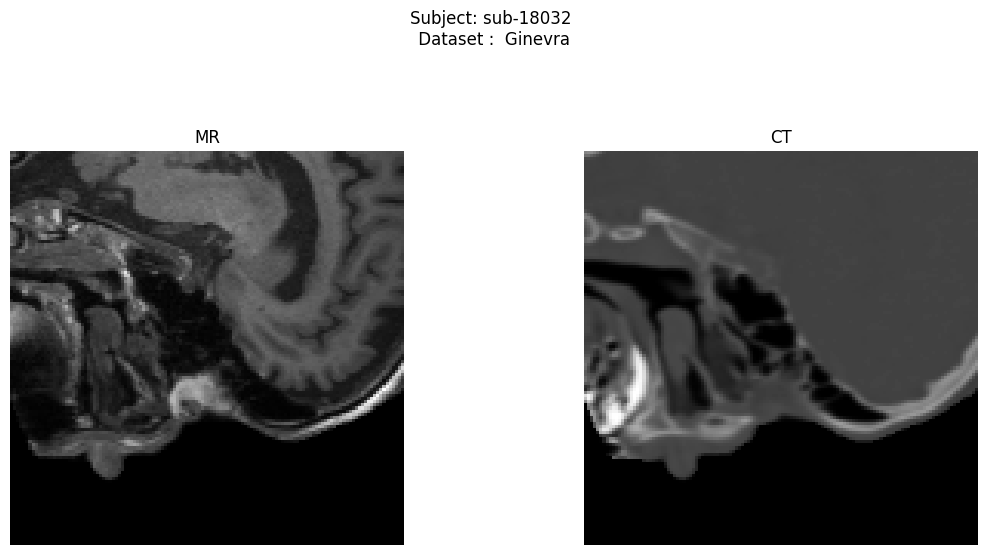

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("MR")
plt.imshow(sample["MR"].cpu()[i,0,50,:,:], cmap="gray")
plt.axis(False)
plt.subplot(1,2,2)
plt.title("CT")
plt.imshow(sample["CT"].cpu()[i,0,50,:,:], cmap="gray")
plt.axis(False)
plt.suptitle(f"Subject: {sample["subject"][i]} \n Dataset :  {sample["dataset"][i]} ", y=1.1,)
plt.tight_layout()
plt.show()

## Model

In [8]:
from models.pix2pix import Pix2Pix

In [9]:
model = Pix2Pix(opt)


unet_128
initialize network with normal
initialize network with normal


In [10]:
trainer = pl.Trainer(
    accelerator="gpu",
    strategy = "ddp_notebook",
    devices=1,
    max_epochs=100,
    check_val_every_n_epoch=5
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model, train_dataloader,val_dataloader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | netG            | UnetGenerator3D       | 131 M  | train
1 | netD            | NLayerDiscriminator3D | 2.6 M  | train
2 | criterionGAN    | GAN_loss_definition   | 0      | train
3 | ssim_loss       | SSIMLoss              | 0      | train
4 | L1_loss         | L1Loss                | 0      | train
5 | perceptual_loss | PerceptualLoss        | 46.2 M | train
------------------------------------------------------------------
134 M     Trainable params
46.2 M    Non-trainab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/multiprocessing/spawn.py", line 90, in _wrap
    fn(i, *args)
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 1012, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 1054, in _run_stage
    self._run_sanity_check()
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/trainer/trainer.py", line 1083, in _run_sanity_check
    val_loop.run()
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py", line 179, in _decorator
    return loop_run(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/loops/evaluation_loop.py", line 138, in run
    batch, batch_idx, dataloader_idx = next(data_fetcher)
                                       ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/loops/fetchers.py", line 134, in __next__
    batch = super().__next__()
            ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/loops/fetchers.py", line 61, in __next__
    batch = next(self.iterator)
            ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/utilities/combined_loader.py", line 341, in __next__
    out = next(self._iterator)
          ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/lightning/pytorch/utilities/combined_loader.py", line 142, in __next__
    out = next(self.iterators[0])
          ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1480, in _next_data
    return self._process_data(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1505, in _process_data
    data.reraise()
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/_utils.py", line 733, in reraise
    raise exception
RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jovyan/work/data/MONAI/monai/transforms/transform.py", line 150, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
                                                                               ^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/transforms/utility/dictionary.py", line 531, in __call__
    d[key] = self.converter(d[key], dtype)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/transforms/utility/array.py", line 490, in __call__
    out, *_ = convert_data_type(
              ^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/utils/type_conversion.py", line 330, in convert_data_type
    data_ = convert_to_tensor(
            ^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/utils/type_conversion.py", line 160, in convert_to_tensor
    return _convert_tensor(data).to(dtype=dtype, device=device, memory_format=torch.contiguous_format)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/cuda/__init__.py", line 305, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/monai/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/jovyan/work/data/MONAI/monai/data/dataset.py", line 108, in __getitem__
    return self._transform(index)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/data/dataset.py", line 94, in _transform
    return self.transform(data_i)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/transforms/compose.py", line 346, in __call__
    result = execute_compose(
             ^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/transforms/compose.py", line 116, in execute_compose
    data = apply_transform(
           ^^^^^^^^^^^^^^^^
  File "/home/jovyan/work/data/MONAI/monai/transforms/transform.py", line 180, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.utility.dictionary.EnsureTyped object at 0x7f54b2768440>

